


In this notebook, we will develop and assess models for estimating the Probability of Default (PD) used by banks to assess credit risk and decide whether to onboard new clients.

We will use both logistic regression and gradient boosted trees. The goal of this project is to demonstrate how these models are applied, how to evaluate their effectiveness, and explore ways to improve performance by selecting optimal parameters.








In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_fscore_support
from sklearn.calibration import calibration_curve
import xgboost as xgb

**Importing Data**

In [4]:
from google.colab import files
import io
uploaded = files.upload()
file_name = list(uploaded.keys())[0];
df_credit_risk = pd.read_csv(io.BytesIO(uploaded[file_name]))

Saving credit_risk_dataset 2.csv to credit_risk_dataset 2.csv


In [5]:
df_credit_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
df_credit_risk.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Data Cleaning

The average loan amount is $9,589.37 ± $6,322.09 with an average interest rate of 11.01% ± 3.24%.
21.8% of all loans in our portfolio have defaulted.
There are data quality problems: age of 144 and employmnet length of 123.

In [8]:
# Summary statistics for categorical values
df_credit_risk.describe(include="O")

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


Most people in the data set rent and take out a loan to fund their education.

From the summary count statistics we can derive that there are columns with missing values. Let's check which columns have the most missing values.

In [9]:
# Calculate the percentage of values being NaN for each column
rows = len(df_credit_risk)
missing = df_credit_risk.isnull().sum()
percentage_missing = missing / rows

# Put the data in a DataFrame and sort it
percentage_missing_df = pd.DataFrame({'Missing' : percentage_missing})
percentage_missing_df.sort_values('Missing', ascending = False, inplace = True)

# Print columns with percentage of missing values
percentage_missing_df.style.format("{:.1%}")

,Missing
loan_int_rate,9.6%
person_emp_length,2.7%
person_age,0.0%
person_income,0.0%
person_home_ownership,0.0%
loan_intent,0.0%
loan_grade,0.0%
loan_amnt,0.0%
loan_status,0.0%
loan_percent_income,0.0%


We are able to verify that the interest rate is missing for 9.6% of rows and the age is missing for 2.7% of rows.

In [10]:
# Find all duplicate rows
duplicates = df_credit_risk[df_credit_risk.duplicated(keep=False)]

# Count occurrences of each duplicated row
duplicate_counts = duplicates.value_counts().reset_index(name='Count')

# Group duplicate rows by their duplication count
duplicate_counts['Count'].value_counts()

,count
Count,
2,137


We have 137 duplicate rows in our data set of +30,000 rows, each appearing twice. Duplicate rows can indicate a data quality problem, especially if the same record is repeated many times. It is however not impossible as our data does not contain any unique identifiers.

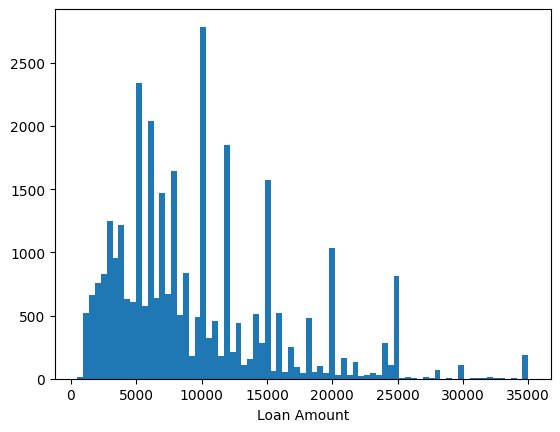

In [11]:
# Look at the distribution of loan amounts with a histogram
n, bins, patches = plt.hist(x=df_credit_risk ['loan_amnt'], bins='auto')
plt.xlabel("Loan Amount")
plt.show()

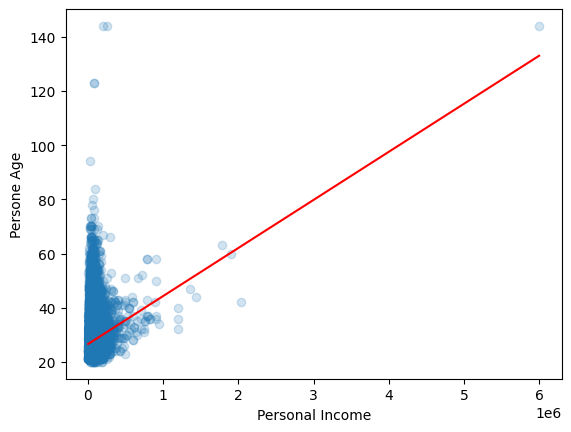

Equation of the trendline: y = 0.00001774x + 26.56


In [12]:
# Plot a scatter plot of income against age
plt.scatter(df_credit_risk['person_income'], df_credit_risk['person_age'], alpha = 0.2)

# Fit a linear regression model using NumPy
coefficients = np.polyfit(df_credit_risk['person_income'], df_credit_risk['person_age'], 1)
linear_fit = np.poly1d(coefficients)

# Generate the x values for the trendline (min and max income values)
income_range = np.linspace(df_credit_risk['person_income'].min(), df_credit_risk['person_income'].max(), 100)

# Plot the trendline
plt.plot(income_range, linear_fit(income_range), color='red', label='Linear Trendline')

plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.show()

# Show trendline equation
slope, intercept = coefficients
equation = f'y = {slope:.8f}x + {intercept:.2f}'
print("Equation of the trendline:", equation)

By analyzing a scatterplot of the age and income of a person, we can spot a positive correlation, which could mean these older recipients are further along in their career and therefore earn higher salaries. There also appears to be some outliers in the data, as well as a data problem with people being older than 120 years.

Cross tables in Python are similar to pivot tables in Excel, you get a high level view of selected columns with aggregation like a count or average. For most credit risk models, especially for probability of default, columns like loan intent and home ownership are common to begin investigating.

In [13]:
# Create a cross table of the loan intent and loan status
pd.crosstab(df_credit_risk['loan_intent'], df_credit_risk['loan_status'], margins=True, normalize='index').style.format("{:.0%}")

loan_status,0,1
loan_intent,,
DEBTCONSOLIDATION,71%,29%
EDUCATION,83%,17%
HOMEIMPROVEMENT,74%,26%
MEDICAL,73%,27%
PERSONAL,80%,20%
VENTURE,85%,15%
All,78%,22%


People taking out loans for debt consolidation, home improvement and medical reasons seem to default more frequently.

In [14]:
# Create a cross table of home ownership, loan status, and grade
pd.crosstab(df_credit_risk['person_home_ownership'], [df_credit_risk['loan_status'], df_credit_risk['loan_grade']], normalize='columns').round(4).style.format("{:.0%}")

Defaulted loans seem to occur more frequently with those who rent.

In [15]:
# Create a cross table of home ownership, loan status, and average percent income
pd.crosstab(df_credit_risk['person_home_ownership'], df_credit_risk['loan_status'], values=df_credit_risk['loan_percent_income'], aggfunc='mean').style.format("{:.0%}")


loan_status,0,1
person_home_ownership,,
MORTGAGE,15%,18%
OTHER,14%,30%
OWN,18%,30%
RENT,14%,26%


The debt-to-income is higher for all types of home ownership when comparing defaults to non-defaults.

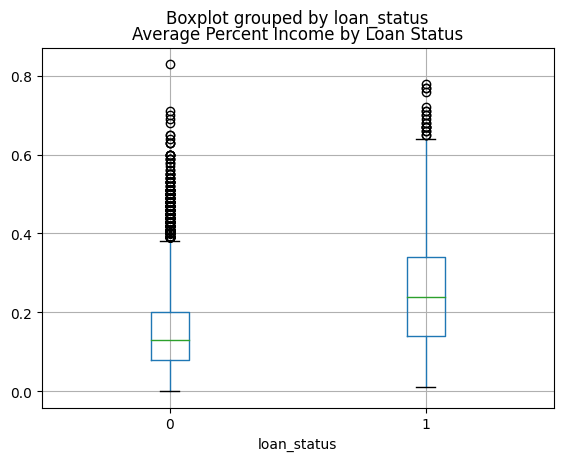

In [16]:
# Create a box plot of percentage income by loan status
df_credit_risk.boxplot(column=['loan_percent_income'], by='loan_status')
plt.title('Average Percent Income by Loan Status')
plt.show()

It looks like the average debt-to-income for defaults is higher. This could indicate those recipients have a debt-to-income ratio that's already too high at acceptance.

Data Cleaning
The first type of preparation we will look at is outlier detection and removal. With outliers in our training data, our predictive models will have a difficult time estimating parameters like coefficients. This can cause our models to not predict as many defaults.

An employment length of over 60 seems highly unlikely, so we will remove those data points.

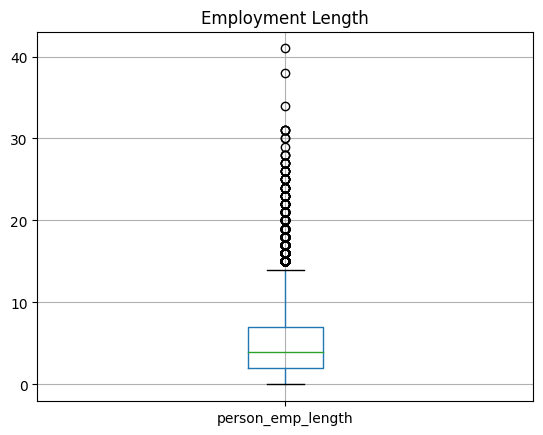

In [17]:
# Create an array of indices where employment length is greater than 60
indices = df_credit_risk[df_credit_risk['person_emp_length'] > 60].index

# Drop the records from the data based on the indices and create a new dataframe
data_clean = df_credit_risk.drop(indices)

# Create a box plot to verify we no longer have excessive employment length results
data_clean.boxplot(column=['person_emp_length'])
plt.title('Employment Length')
plt.show()

In [21]:
#An employment length between 0 and 41 seems reasonable.

#Earlier we noticed some records with ages above 120, let's fix this data quality issue.

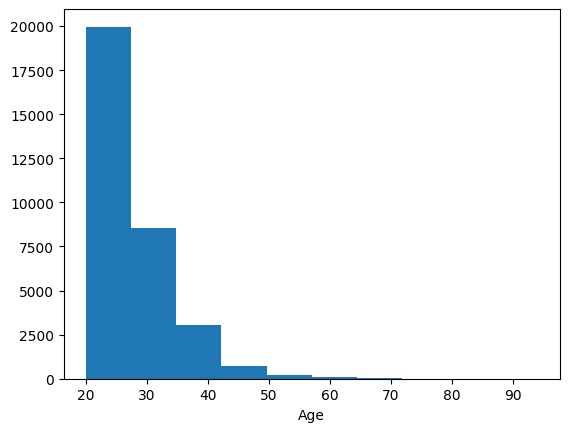

In [18]:
# Use Pandas to drop the record from the data frame and create a new one
data_clean = data_clean.drop(data_clean[data_clean['person_age'] > 100].index)

# Look at the distribution of ages with a histogram
n, bins, patches = plt.hist(x=data_clean['person_age'])
plt.xlabel("Age")
plt.show()

<ipython-input-44-ccd9f773cc01>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean['person_emp_length'].fillna((data_clean['person_emp_length'].median()), inplace=True)


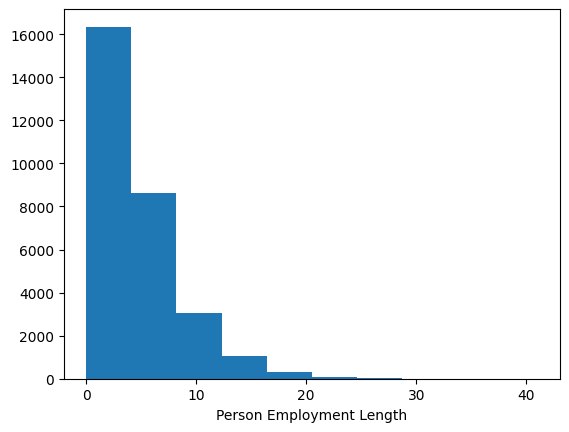

In [44]:
# Impute the null values with the median value for all employment lengths
data_clean['person_emp_length'].fillna((data_clean['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(data_clean['person_emp_length'])
plt.xlabel("Person Employment Length")
plt.show()

Employment length is right-skewed as younger people tend to apply more often for loans than older people who have worked for longer.

In [45]:
# Store the array on indices
indices = data_clean[data_clean['loan_int_rate'].isnull()].index

# Save the new data without missing data
data_clean = data_clean.drop(indices)

# Calculate the percentage of values being NaN for each column
rows = len(data_clean)
missing = data_clean.isnull().sum()
percentage_missing = missing / rows

# Put the data in a DataFrame and sort it
percentage_missing_df = pd.DataFrame({'Missing' : percentage_missing})
percentage_missing_df.sort_values('Missing', ascending = False, inplace = True)

# Print columns with percentage of missing values
percentage_missing_df.style.format("{:.1%}")

,Missing
person_age,0.0%
person_income,0.0%
person_home_ownership,0.0%
person_emp_length,0.0%
loan_intent,0.0%
loan_grade,0.0%
loan_amnt,0.0%
loan_int_rate,0.0%
loan_status,0.0%
loan_percent_income,0.0%


There are no more columns with missing data as we either dropped those rows or imputed those values.


**Logistic Regression**

Probability of default is the likelihood that someone will fail to repay a loan. This is expressed as a probability which is a value between zero and one. These probabilities are associated with our loan status column where a 1 is a default, and a 0 is a non-default. The resulting predictions give us probabilities of default. The closer the value is to 1, the higher the probability of the loan being a default.

To get these probabilities, we train machine learning models on our credit data columns, known as features, so the models learn how to use the data to predict the probabilities. These types of models are known as classification models, where the class is default or non-default. In the industry, two models are used frequently. These are logistic regressions, and decision trees. Both of these models can predict the probability of default, and tell us how important each column is for predictions.

The logistic regression is a regression that only produces a value between 0 and 1. Logistic regressions perform better on data when what determines a default or non-default can vary greatly.

Scikit learn has a logistics model function that will optimize the feature coeffiecients through brute force trial-and-error.

We will need to split our data in two separate groups, part of our data we will use to train our model - the training set - another part of our data we will use to test and validate the performance of our model - the test set. We use the majority of the data to train our models, so they learn as much as possible from the data. Our test set is used to see how our model reacts to new data that it has not seen before.

In [46]:
# Create the X and y data sets
X = data_clean[['loan_int_rate','person_emp_length','person_income', 'loan_amnt']]
y = data_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
X_test_performance = X_test[['loan_amnt']]
X_train = X_train[['loan_int_rate','person_emp_length','person_income']]
X_test = X_test[['loan_int_rate','person_emp_length','person_income']]

In [49]:
# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Print the models coefficients
clf_logistic.coef_

array([[ 2.88774130e-01, -2.19063447e-02, -1.99385087e-05]])

These coefficients indicate the importance of each column. These values are part of the logistic regression formula that calculates the probability of default.

Our data contains non-numeric columns like loan intent, which uses words to describe how the person plans to use the money we lend them. We have to perform one-hot encoding before we can use them. The main idea is to represent a string with a numeric value. This will get us a new set of columns where each value from loan intent is now its own column. Each new column is created by separating out the loans with each intent value and making the new column's value a 0 or 1. For example, if the loan intent was education, it is now represented with a 1 in the loan intent education column. This way, there is one hot value.

To one-hot encode our string columns, we use the get dummies function within pandas. First, we separate the numeric and non-numeric columns from the data into two sets. Then we use the get dummies function to one-hot encode only the non-numeric columns. We union the two sets and the result is a full data set.

Once our model is trained, we use the predict proba method on test data to make predictions. This creates a set of probabilities for non-default and default. Notice the output is a series of numbers between 0 and 1. We have two for each loan. The first number is the probability of non-default, and the second number is the probability of default.

In [51]:
# Create two data sets for numeric and non-numeric data
data_num = data_clean.select_dtypes(exclude=['object'])
data_str = data_clean.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
data_str_onehot = pd.get_dummies(data_str)

# Union the one-hot encoded columns to the numeric ones
data_prep = pd.concat([data_num, data_str_onehot], axis=1)

# Print the columns in the new data set
data_prep.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')

In [52]:
# Create the X and y data sets
X = data_prep.drop(columns=['loan_status'])
y = data_prep[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1).style.format({"prob_default":"{:.1%}"})

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,loan_status,prob_default
0,1,14.6%
1,1,46.7%
2,0,24.2%
3,0,10.1%
4,1,9.0%


The first five rows don't look very promising, defaulted loans seem to have a low PD.

**Model Evaluation**

There are several metric to evaluate the performance of a model.

Accuracy: Accuracy is the number of correct predictions divided by the total number of predictions.
ROC charts: ROC charts plot the true positive rate, the percentage of correctly predicted defaults, against the false positive rate, the percentage of incorrectly predicted defaults. The more the ROC curve goes towards the top-left corner (lift) the better the models predictions. This allows us to calculate the area under the curve (AUC), representing the space between the curve and a random model indicated by a straight diagonal line.

In [53]:
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the row counts for each loan status
preds_df['loan_status'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,count
loan_status,
0,10289
1,1495


We classify loans with a PD of more than 50% as default loans. This gets us 609 defaulted loans vs 11,175 non-defaulted loans.

In [54]:
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.84      0.94      0.89      9198
     Default       0.66      0.38      0.48      2586

    accuracy                           0.82     11784
   macro avg       0.75      0.66      0.69     11784
weighted avg       0.80      0.82      0.80     11784



Recall is the proportion of actual positives correctly predicted. This is found by taking the number of true defaults and dividing it by the sum of true defaults and defaults predicted as non-default. For our model the recall for defaults is 17%, meaning that only 17% of our defaulted loans were predicted as defaults.

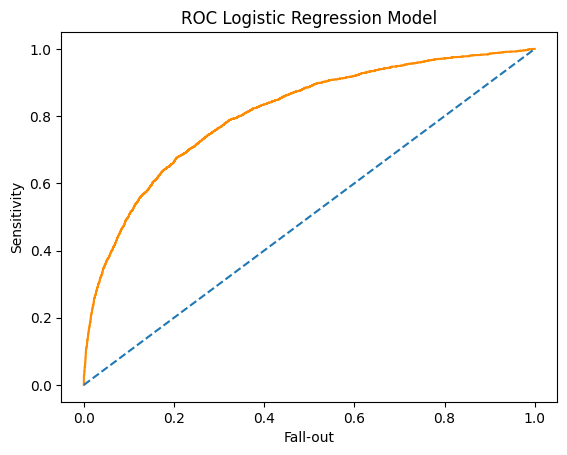

Accuracy: 0.8203496266123558
AUC: 0.8089553245291732


In [55]:
# Create predictions and store them in a variable
preds = clf_logistic.predict_proba(X_test)

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.title("ROC Logistic Regression Model")
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)

# Print the accuracy and AUC score the model
print("Accuracy:", clf_logistic.score(X_test, y_test))
print("AUC:", auc)

The ROC curve shows the trade-off between the false positive rate (fall-out) on the x-axis, and the true positive rate (sensitivity) on the y-axis. The accuracy for this model is about 80% and the AUC score is 76%.

In [56]:
# Set the threshold for defaults to 0.5
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the confusion matrix
print("Default threshold 50%\n", confusion_matrix(y_test,preds_df['loan_status']),"\n")

# Set the threshold for defaults to 0.4
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Print the confusion matrix
print("Default threshold 40%\n", confusion_matrix(y_test,preds_df['loan_status']))


Default threshold 50%
 [[8685  513]
 [1604  982]] 

Default threshold 40%
 [[8190 1008]
 [1232 1354]]


A confusion matrix shows use true and false positives and negatives. We get a much better default recall when lowering our PD threshold to classify defaults. 50%: 434 vs 40%: 1,200

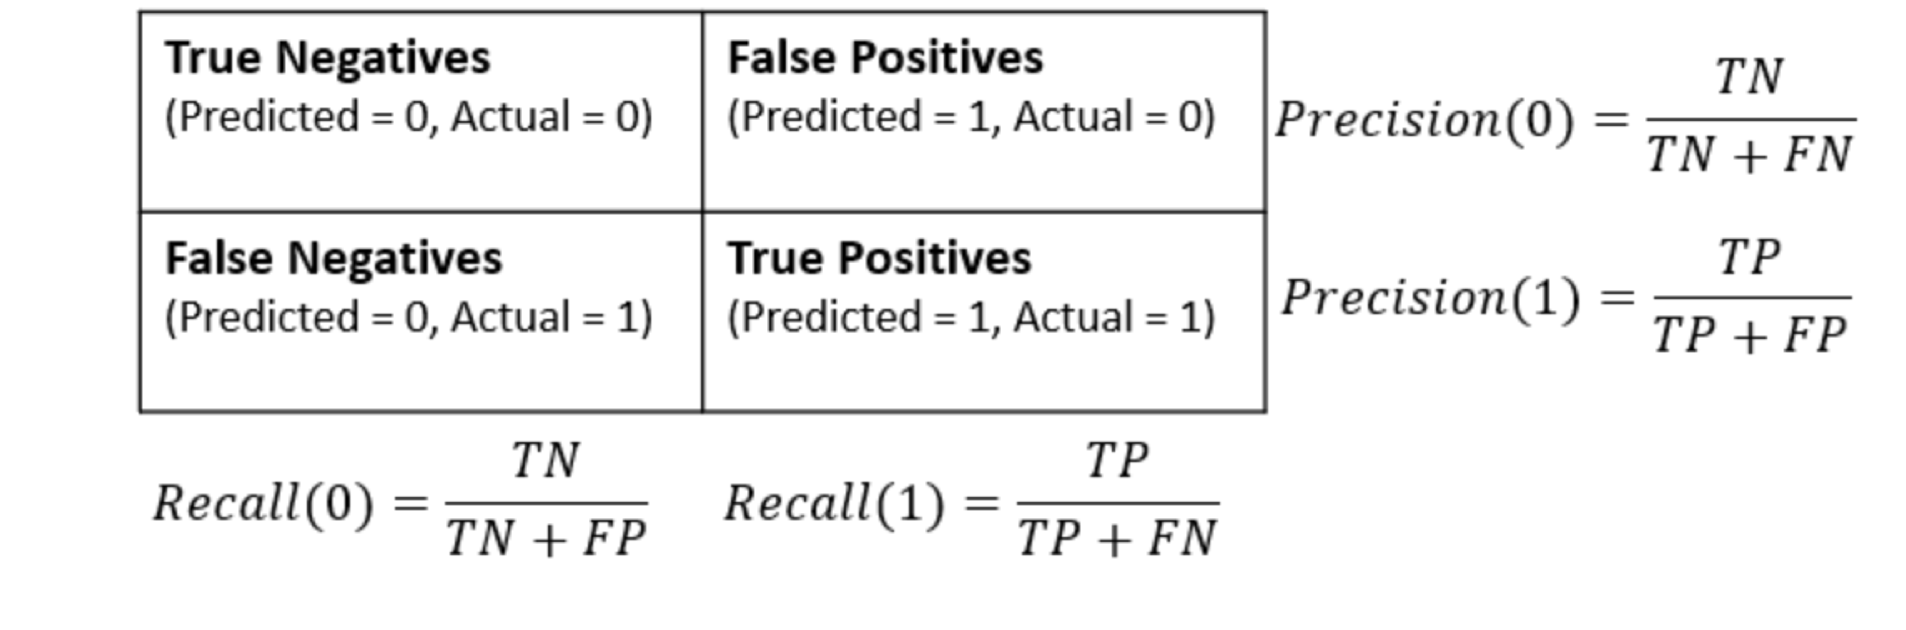

In [57]:
# Reassign the values of loan status based on the new threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Store the number of loan defaults from the prediction data
num_defaults = preds_df['loan_status'].value_counts()[1]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
print(num_defaults * avg_loan_amnt * (1 - default_recall))

10790764.303214505


We calculate the unexpected loss by multiplying the amount of loans we did not identify as default but actually defaulted by the average loan amount. With a PD threshold of 40% this would be $9.8M. We need to check other thresholds to see if those would result in a lower unexpected loss.

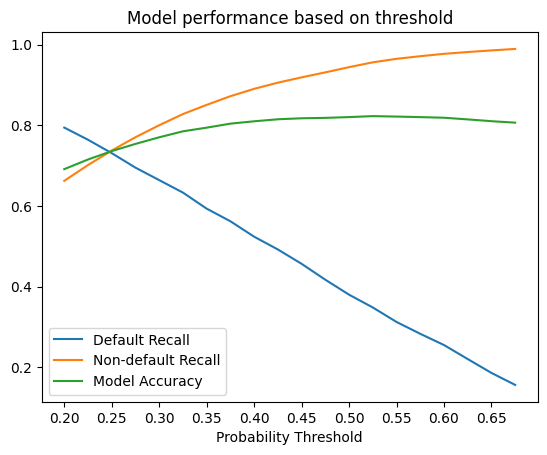

[0.0064757344101336045, 0.25]

In [58]:
thresh = [0.2 + i * 0.025 for i in range(20)]
ticks = [thresh[i] for i in range(len(thresh)) if i % 2 == 0]
def_recalls = []
nondef_recalls = []
accs = []

for thresh_value in thresh:
    # Reassign the values of loan status based on the new threshold
    preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > thresh_value else 0)

    # Store the default recall from the classification report
    default_recall = precision_recall_fscore_support(y_test, preds_df['loan_status'])[1][1]
    nondefault_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][0]
    accuracy = accuracy_score(y_test,preds_df['loan_status'])

    # Append the default recall value to the list
    def_recalls.append(default_recall)
    nondef_recalls.append(nondefault_recall)
    accs.append(accuracy)

plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.xticks(ticks)
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.title("Model performance based on threshold")
plt.show()

# Find the threshold where default recall and non-default recall intersect
intersect = [1, 1]
for i, thresh_value in enumerate(thresh):
    difference = abs(def_recalls[i] - nondef_recalls[i])
    if (difference < intersect[0]):
        intersect = [difference, thresh_value]

intersect


There is a trade off between metrics like default recall, non-default recall, and model accuracy. The graph above shows us the performance of those parameters based on the probability threshold. Where the lines intersect shows us the optimal trade-off, in this case being a PD of 0.275. This threshold would make a great starting point, but declaring all loans above 0.275 PD to be a default is probably not practical.

**Gradient Boosted Trees with XGBoost**

Gradient boosted trees are machine learning models which use decisions as steps in a process to eventually identify our loan status. The results of these steps are yes and no decisions that eventually lead to a predicted loan status of default or non-default. XGBoost doesn't use just one decision tree, but a large number of them in what's known as an ensemble through a method called gradient boosting. Each tree in the ensemble is a weak predictor, combined they are much better. These models predict the same way in Python as the logistic regression do.

The models have parameters that are like settings that affect how a model learns. These settings are called hyperparameters. Hyperparameters cannot be learned from data; they have to be set by us. The learning rate tells the model how quickly it should learn in each step of the ensemble. The smaller the value, the more conservative it is at each step. The max depth tells the model how deep each tree can go. Keeping this value low ensures the model is not too complex.

In [59]:
# Train a model
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
gbt_preds_df = pd.DataFrame(gbt_preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Concatenate and print the two data frames for comparison
pd.concat([true_df.reset_index(drop = True), gbt_preds_df], axis = 1).style.format({"prob_default":"{:.1%}"})

,loan_status,prob_default
0,1,99.3%
1,1,93.3%
2,0,0.1%
3,0,0.2%
4,1,7.4%


At first glance, the XGBoost model seems to predict defaults better - getting 2 out of 3 - than logistic regression.

In [60]:
# Print the first five rows of the portfolio data frame
lr_preds_df = preds_df.drop(columns=['loan_status'])
lr_preds_df.columns = ['lr_prob_default']
gbt_preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['gbt_prob_default'])
portfolio = pd.concat([X_test_performance.reset_index(drop = True), lr_preds_df, gbt_preds_df], axis=1)
print(portfolio.head())

# Create expected loss columns for each model using the formula
lgd = 0.2
portfolio['lr_expected_loss'] = portfolio['lr_prob_default'] * lgd * portfolio['loan_amnt']
portfolio['gbt_expected_loss'] = portfolio['gbt_prob_default'] * lgd * portfolio['loan_amnt']

# Print the sum of the expected loss for lr and gbt
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

   loan_amnt  lr_prob_default  gbt_prob_default
0      15000         0.146187          0.993436
1      11200         0.466764          0.932854
2      15000         0.241531          0.000790
3      10800         0.100799          0.001739
4       3000         0.090226          0.073660
LR expected loss:  5868073.521897038
GBT expected loss:  5364696.486396759


Expected loss (EL) = probability of default (PD) loss given default (LGD) exposure at default (EAD)

In this case we assume the LGD to be a fixed 20%, in a real use case, this would also be moddeled.

It looks like the total expected loss for the XGBoost model is quite a bit lower ($212,794.08) than the one of the logsitic regression model. When we talk about accuracy and precision, the goal is to generate models which have a low expected loss.

In [61]:
# Predict the labels for loan status
gbt_preds = clf_gbt.predict(X_test)

# Check the values created by the predict method
print(gbt_preds)

# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))


[1 1 0 ... 0 0 0]
              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.94      0.73      0.82      2586

    accuracy                           0.93     11784
   macro avg       0.93      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784



The default recall for the logistic regression model was only 17%. The XGBoost model offers a big improvement on this front with a default recall of 74%. All recall and precision parameters of this model are very high and quite a bit better than those of the logistic regression.

In [62]:
X = data_prep[['person_income','loan_int_rate', 'loan_percent_income','loan_amnt', 'person_home_ownership_MORTGAGE','loan_grade_F']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
clf_gbt.get_booster().get_score(importance_type = 'weight')

{'person_income': 1137.0,
 'loan_int_rate': 1255.0,
 'loan_percent_income': 688.0,
 'loan_amnt': 626.0,
 'person_home_ownership_MORTGAGE': 153.0,
 'loan_grade_F': 20.0}

The coefficients of a logistic regression indicate the importance of each column in predicting the outcome. For gradient boosted trees we can look at the weight, this will give us how many times the columns appear in all the models' trees.



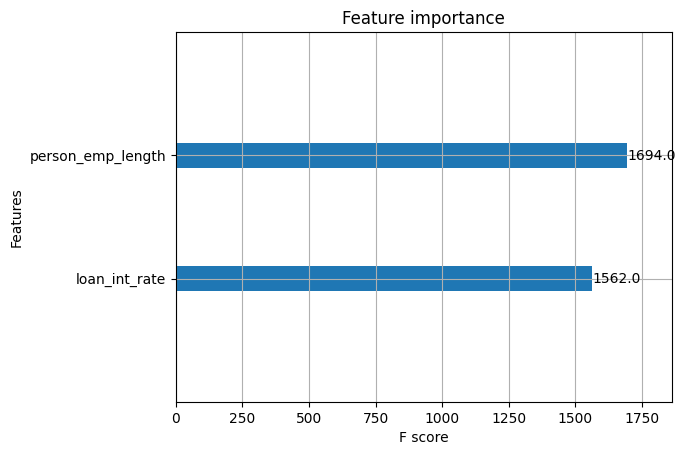

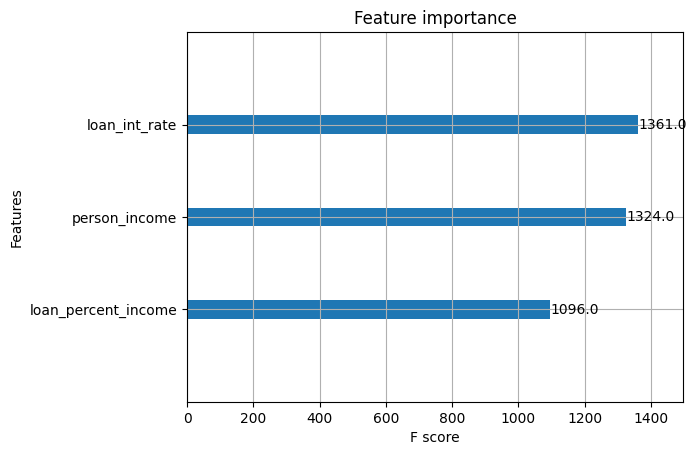

In [63]:
X2 = data_prep[['loan_int_rate','person_emp_length']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=.4, random_state=123)

# Train a model on the X data with 2 columns
clf_gbt2 = xgb.XGBClassifier().fit(X2_train,np.ravel(y2_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt2, importance_type = 'weight')
plt.show()

# Add DTI to our model parameters
X3 = data_prep[['person_income','loan_int_rate','loan_percent_income']]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=.4, random_state=123)

# Train a model on the X data with 3 columns
clf_gbt3 = xgb.XGBClassifier().fit(X3_train,np.ravel(y3_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt3, importance_type = 'weight')
plt.show()

The amount of columns used to train the model can affect the importance of them. In this case adding the Income column reduced the weight of the Interest Rate column from 1,490 to 1,013.

In [64]:
# Create data sets and models
X = data_prep[['person_income','loan_int_rate', 'loan_percent_income', 'loan_amnt', 'person_home_ownership_MORTGAGE']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

X2 = data_prep[['person_income','loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership_RENT']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=.4, random_state=123)
gbt2 = xgb.XGBClassifier().fit(X2_train, np.ravel(y2_train))

# Predict the loan_status using each model
gbt_preds = gbt.predict(X_test)
gbt2_preds = gbt2.predict(X2_test)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

# Print the classification report of the second model
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.90      0.95      0.93      9198
     Default       0.79      0.64      0.71      2586

    accuracy                           0.88     11784
   macro avg       0.85      0.80      0.82     11784
weighted avg       0.88      0.88      0.88     11784

              precision    recall  f1-score   support

 Non-Default       0.91      0.97      0.94      9198
     Default       0.87      0.64      0.74      2586

    accuracy                           0.90     11784
   macro avg       0.89      0.81      0.84     11784
weighted avg       0.90      0.90      0.89     11784



It can be difficult to use two metrics like accuracy and recall to gauge a model's performance. The F1 score is a combination of both precision and recall. This is useful because it helps us keep recall for loan defaults as an important consideration for any model.

F1 = 2 (precision recall) / (precision + recall)

In [65]:
# Create data sets and models
X = data_prep.drop(columns=['loan_status'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10
params = {'objective': 'binary:logistic', 'seed': 123, 'eval_metric': 'auc'}

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds, early_stopping_rounds=early_stopping).style.format("{:.1%}")

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,90.0%,0.1%,89.5%,0.4%
1,91.0%,0.3%,90.4%,0.3%
2,91.7%,0.2%,90.9%,0.4%
3,92.2%,0.1%,91.4%,0.6%
4,92.6%,0.2%,91.7%,0.4%


Cross validation is a method for training and testing a model multiple times on the same data with different hyperparameters. We cannot create more loan data to help us develop our model, but we can use cross validation to simulate how our model will perform on new loan data before it comes in.

We take the entire set of training data and create pieces, called folds, from it. All but one of the folds are used for training, and the remaining fold is used as a kind of miniature test set. Once testing on all folds is completed, the model is tested against the actual test set. This is done through multiple splits so each fold is used for testing at least once. Once this is done, the parameters are averaged across each training session and then the model is finally tested against the original test set.

The AUC for both train-auc-mean and test-auc-mean improves at each iteration of cross-validation.

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.900347       0.001478       0.893751      0.008880
1        0.907647       0.001643       0.902234      0.006378
2        0.916727       0.002286       0.910633      0.006879
3        0.921605       0.001369       0.914172      0.007943
4        0.924778       0.000748       0.916078      0.007811
Mean test AUC score: 0.94


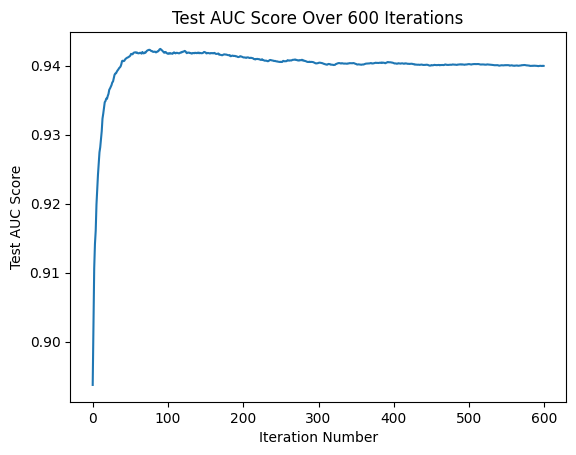

In [66]:
cv_results_big = xgb.cv(params, DTrain, num_boost_round = 600, nfold=10, shuffle = True)

# Print the first five rows of the CV results data frame
print(cv_results_big.head())

# Calculate the mean of the test AUC scores
print("Mean test AUC score:", np.mean(cv_results_big['test-auc-mean']).round(2))

# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()
